# Sensitivity analysis

In [59]:
from SALib.sample import saltelli, fast_sampler
from SALib.analyze import sobol, fast
from SALib.plotting.bar import plot as barplot
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

# function for reading csv files
def pd_read_pattern(pattern, sep):
    files = glob.glob(pattern)
    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f, sep=sep))
    return df.reset_index(drop=True)

# function to remove files
def removeFiles(pattern):
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except:
            print("Error while deleting file : ", file)

# read output files
def readOutput(read_raw_files, path, output_path, result_file_name):
    if (read_raw_files):
        df = pd_read_pattern(path + "group*.csv", sep=";")
        params = pd_read_pattern(path + "par*.csv", sep=";")
        params = params.drop(columns=["replicate"])
        df.iteration = df.iteration.astype(float)
        df = df.sort_values(by=['iteration'])
        df = pd.merge(df, params, on="iteration")
        df.to_csv(output_path + result_file_name + ".csv", index=False)
    else:
        df = pd.read_csv(output_path + result_file_name + ".csv")
    
    return df
        

In [28]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 1],
               [0, 0.60],
               [0, 0.30]]
}

# Sobol

In [49]:
sample_parameters = False
if (sample_parameters):
    param_values = saltelli.sample(problem, 2**3)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-sobol.csv")
len(t)

64

In [60]:
df = readOutput(True, "../models/fertility-BMI/output/", "../output/data/", 
    "results-sobol")
# select valid iterations
df = df.loc[df["iteration"] <= len(t),:]
# define outcome
Y = df.g4.to_numpy()
len(Y)

64

In [61]:
df

,iteration,replicate,time,population_x,g1,g2,g3,g4,mating,kid-father-cor,kid-mother-cor,population_y,fertility_type,heritability_type,mating_type,random_mating,leakage,fertility_factor
0,1.0,1,100.0,2911,0.069735,0.160769,0.325318,0.444177,0.873025,0.778171,0.777423,1000,additive,preston,defined,0.09375,0.28125,0.140625
1,2.0,1,100.0,2258,0.139504,0.177591,0.332595,0.350310,0.169754,0.498390,0.487822,1000,additive,preston,defined,0.65625,0.28125,0.140625
2,3.0,1,100.0,3289,0.071450,0.125570,0.291578,0.511402,0.864743,0.826163,0.827519,1000,additive,preston,defined,0.09375,0.16875,0.140625
3,4.0,1,100.0,2923,0.071502,0.182689,0.344851,0.400958,0.869412,0.750500,0.749032,1000,additive,preston,defined,0.09375,0.28125,0.290625
4,5.0,1,100.0,2236,0.047406,0.133721,0.269231,0.549642,0.848296,0.797243,0.795026,1000,additive,preston,defined,0.09375,0.16875,0.290625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60.0,1,100.0,2656,0.115587,0.207831,0.342997,0.333584,0.722242,0.626189,0.624120,1000,additive,preston,defined,0.21875,0.50625,0.178125
60,61.0,1,100.0,3312,0.061896,0.138889,0.344203,0.455012,0.708020,0.728940,0.726666,1000,additive,preston,defined,0.21875,0.24375,0.178125
61,62.0,1,100.0,2673,0.142536,0.202768,0.315376,0.339319,0.325283,0.506705,0.498242,1000,additive,preston,defined,0.53125,0.50625,0.178125
62,63.0,1,100.0,2682,0.225578,0.268084,0.257644,0.248695,0.341626,0.597480,0.594252,1000,additive,preston,defined,0.53125,0.24375,0.028125


In [63]:
Si = sobol.analyze(problem, Y, print_to_console=True)

                     ST   ST_conf
random-mating  0.139694  0.325629
leakage        0.430321  0.409685
fertility      0.167171  0.408093
                     S1   S1_conf
random-mating -0.185930  0.313299
leakage        0.553196  0.927573
fertility     -0.030197  0.289359
                                  S2   S2_conf
(random-mating, leakage)    0.078256  0.559728
(random-mating, fertility) -0.000851  0.454337
(leakage, fertility)       -0.392409  0.962251


In [43]:
total, first, second = Si.to_df()

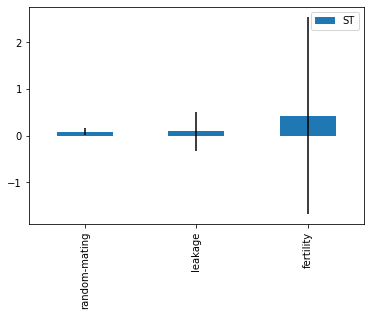

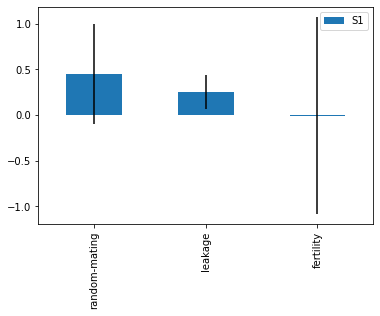

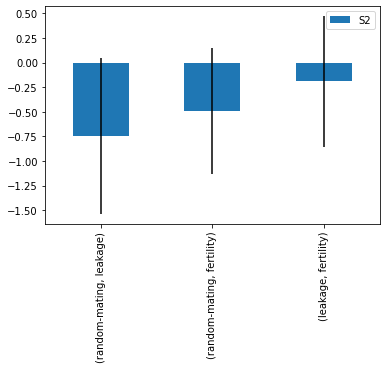

In [44]:
st = barplot(total)
plt.savefig("../output/plots/sobol-st.pdf", bbox_inches='tight')
s1 = barplot(first)
plt.savefig("../output/plots/sobol-s1.pdf", bbox_inches='tight')
s2 = barplot(second)
plt.savefig("../output/plots/sobol-s2.pdf", bbox_inches='tight')

# EFast

In [64]:

sample_parameters = True

if (sample_parameters):
    param_values = fast_sampler.sample(problem, 1000)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-efast.csv")

In [20]:
df = readOutput(True, "../models/fertility-BMI/output/", "../output/data/", 
    "results-efast")
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)

3000

In [21]:
df.g4.describe()

count    3000.000000
mean        0.376931
std         0.126163
min         0.000000
25%         0.297823
50%         0.349927
75%         0.422917
max         0.977778
Name: g4, dtype: float64

In [22]:
Sif = fast.analyze(problem, Y, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.066447  0.356710  0.006237  0.029444
leakage        0.395304  0.714124  0.007467  0.028034
fertility      0.209558  0.424719  0.007934  0.027591


<AxesSubplot:>

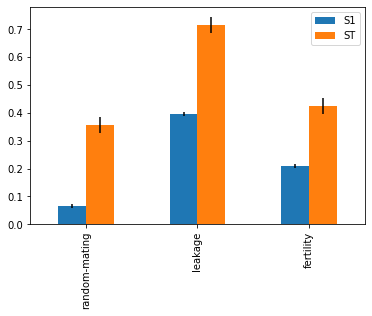

In [8]:
Sif.plot()

In [88]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.7),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [89]:
fig.write_image("../output/plots/3D-scatter-efast.pdf")